In [27]:
from loss_traces.results.result_processing import (
    get_lira_scores,
    get_overall_tpr_at_fpr,
    get_attackr_scores,
    get_rmia_scores,
    get_trace_reduction,
)
import pandas as pd

from matplotlib import pyplot as plt
from sklearn import metrics
import numpy as np
from loss_traces.attacks import AttackConfig, RMIAAttack, LiRAAttack, AttackR
from collections import defaultdict
from sklearn.metrics import roc_auc_score, roc_curve

plt.style.use("plot_style.mplstyle")


# Figure 3

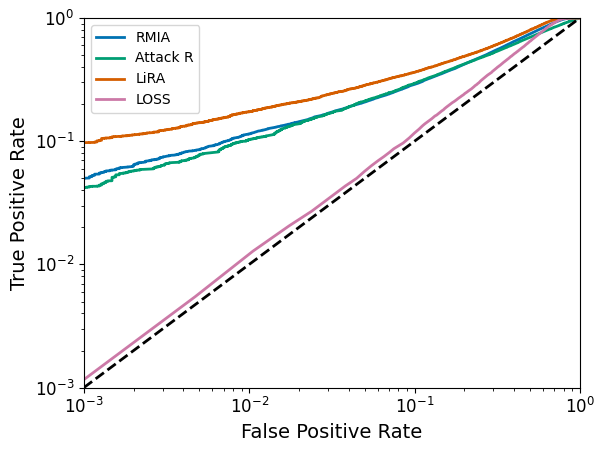

In [3]:
def print_overall_tpr_at_fpr(df: pd.DataFrame, target_col="lira_score"):

    fpr, tpr, _thresholds = metrics.roc_curve(df['target_trained_on'], df[target_col], drop_intermediate=False)
    plt.plot(fpr, tpr)
    plt.xlim(left=0)

exp_id = "wrn28-2_CIFAR10"

label_mapping = {
    "lira_score": "LiRA", 
    "loss attack": "Loss Attack", 
    "final loss": "Final loss", 
    "loss iqr (75%-25%)": "LT-IQR (75%-25%)", 
    "attackr_score": "Attack R", 
    "rmia_score": "RMIA", 
    "random_guessing": "Random guessing"
}
    
df = get_lira_scores(exp_id)
df["rmia_score"] = get_rmia_scores(exp_id)
df["attackr_score"] = get_attackr_scores(exp_id)
df["lt_iqr"] =  get_trace_reduction(exp_id, reduction="iqr") 
df["loss attack"]  = -get_trace_reduction(exp_id, first=-1, reduction=None)


label_mapping["loss attack"] = "LOSS"

plt.figure()
for a in ["rmia_score", "attackr_score", "lira_score", "loss attack"]:
    fpr, tpr, _thresholds = metrics.roc_curve(df['target_trained_on'], df[a], drop_intermediate=False)
    plt.plot(fpr, tpr, label=label_mapping[a])

plt.axline((0, 0), slope=1, color="black", linestyle="dashed")
plt.xscale("log")
plt.yscale("log")
plt.ylim(bottom=0.001)
plt.xlim(left=0.001)

plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.savefig(f"./roc_curve_{exp_id}.pdf", bbox_inches="tight")
plt.show()


In [4]:
for attack in ["rmia_score", "attackr_score", "lira_score", "loss attack"]:
    auc = metrics.roc_auc_score(df['target_trained_on'], df[attack])
    print(f"{label_mapping[attack]} AUC: {auc:.3f}")


RMIA AUC: 0.694
Attack R AUC: 0.659
LiRA AUC: 0.741
LOSS AUC: 0.609


# Figure 4

In [5]:
exp_id = "wrn28-2_CIFAR10"
level = 0.001



def get_matrix_attack_comparison(exp_id, level):
    """
    Compare different membership inference attacks at a specific FPR level.
    
    Args:
        exp_id: Experiment identifier
        level: FPR level for threshold calculation
        
    Returns:
        Dictionary mapping attack names to vulnerable members
    """
    df = get_lira_scores(exp_id)
    df['attackr_score'] = get_attackr_scores(exp_id)
    df['rmia_score'] = get_rmia_scores(exp_id)['rmia_2.0_new_score']
    df['loss attack'] = -get_trace_reduction(exp_id, first=-1)
    df["lt_iqr"] = get_trace_reduction(exp_id, reduction="iqr")
    
    benchmarks = ['lira_score', 'attackr_score', 'rmia_score', 'loss attack']
    
    members = df[df['target_trained_on'] == True]
    members_dict = {}
    
    for attack_score in benchmarks:
        attack_scores = df[attack_score]
        
        fprs, _tprs, thresholds = metrics.roc_curve(df['target_trained_on'], attack_scores, drop_intermediate=False)
        threshold = thresholds[np.where(fprs <= level)[0][-1]]
        print(f"{attack_score}: threshold = {threshold}")

        vulnerable = members.loc[members[attack_score] >= threshold][attack_score]
        members_dict[attack_score] = vulnerable
    
    return members_dict

for level in [0.001]:
    members_dict = get_matrix_attack_comparison(exp_id, level)
    
df = get_lira_scores(exp_id)
df['attackr_score'] = get_attackr_scores(exp_id)
df['rmia_score'] = get_rmia_scores(exp_id)['rmia_2.0_new_score']


print(get_overall_tpr_at_fpr(df, 0.00, "rmia_score"))

# Number of members vulnerable to all three attacks
print("LiRA & RMIA & AttackR:", len(set(members_dict["lira_score"].index) & set(members_dict["rmia_score"].index) & set(members_dict["attackr_score"].index)))

# Number of members vulnerable to LiRA and AttackR but not RMIA
print("LiRA & AttackR but not RMIA:", len(set(members_dict["lira_score"].index).intersection(set(members_dict["attackr_score"].index)) - set(members_dict["rmia_score"].index)))

# Number of members vulnerable to LiRA and RMIA but not AttackR
print("LiRA & RMIA but not AttackR:", len(set(members_dict["lira_score"].index).intersection(set(members_dict["rmia_score"].index)) - set(members_dict["attackr_score"].index)))

# Number of members vulnerable to only LiRA
print("LiRA but not RMIA or AttackR:", len(set(members_dict["lira_score"].index) - (set(members_dict["rmia_score"].index)) - set(members_dict["attackr_score"].index)))

# Number of members vulnerable to only AttackR
print("AttackR but not LiRA or RMIA:", len(set(members_dict["attackr_score"].index) - (set(members_dict["rmia_score"].index)) - set(members_dict["lira_score"].index)))

# Number of members vulnerable to AttackR and RMIA but not LiRA
print("AttackR & RMIA but not LiRA:", len(set(members_dict["attackr_score"].index).intersection(set(members_dict["rmia_score"].index)) - set(members_dict["lira_score"].index)))

# Number of members vulnerable to RMIA and LiRA but not AttackR
print("RMIA & LiRA but not AttackR:", len(set(members_dict["rmia_score"].index).intersection(set(members_dict["lira_score"].index)) - set(members_dict["attackr_score"].index)))

# Number of members vulnerable to RMIA but not LiRA or AttackR
print("RMIA but not LiRA or AttackR:", len(set(members_dict["rmia_score"].index) - (set(members_dict["lira_score"].index)) - set(members_dict["attackr_score"].index)))



lira_score: threshold = 27.983934505509914
attackr_score: threshold = 0.9983690692098915
rmia_score: threshold = 2131.0
loss attack: threshold = inf
0.01872
LiRA & RMIA & AttackR: 796
LiRA & AttackR but not RMIA: 168
LiRA & RMIA but not AttackR: 316
LiRA but not RMIA or AttackR: 1156
AttackR but not LiRA or RMIA: 33
AttackR & RMIA but not LiRA: 57
RMIA & LiRA but not AttackR: 316
RMIA but not LiRA or AttackR: 83


# Table 6

In [23]:
members_dict.keys()

union_members = set()
for attack in ["lira_score", "attackr_score", "rmia_score"]:
    union_members.update(set(members_dict[attack].index))

print(f"Total unique members across all attacks: {len(union_members)}")

Total unique members across all attacks: 2609


In [25]:
# First, we need to run RMIA with 2 shadow models

dataset = "CIFAR10"
arch = "wrn28-2"
exp_id = f"{arch}_{dataset}"

all_attacks_results = defaultdict(dict)

for n_shadows in (8, 32, 128):
    config = AttackConfig(
        exp_id=exp_id,
        target_id="target",
        checkpoint=None,
        arch=arch,
        dataset=dataset,
        attack="LiRA",
        augment=True,
        batchsize=32,
        num_workers=8,
        gpu=":1",
        n_shadows=n_shadows, # shows number of in/out models separately, total number if shadow models is double that if online
    )
    attack = LiRAAttack(config)
    all_attacks_results["lira"][n_shadows] = attack.run()

    config = AttackConfig(
        exp_id=exp_id,
        target_id="target",
        checkpoint=None,
        arch=arch,
        dataset=dataset,
        attack="AttackR",
        augment=True,
        batchsize=32,
        num_workers=8,
        gpu=":1",
        n_shadows=n_shadows, # shows number of in/out models separately, total number if shadow models is double that if online
    )
    attack = AttackR(config)
    all_attacks_results["attackr"][n_shadows] = attack.run()

    config = AttackConfig(
        exp_id=exp_id,
        target_id="target",
        checkpoint=None,
        arch=arch,
        dataset=dataset,
        attack="RMIA",
        augment=True,
        batchsize=32,
        num_workers=8,
        gpu=":1",
        n_shadows=n_shadows, # shows number of in/out models separately, total number if shadow models is double that if online
    )
    attack = RMIAAttack(config)
    all_attacks_results["rmia"][n_shadows] = attack.run()

n_shadows = 1
config = AttackConfig(
    exp_id=exp_id,
    target_id="target",
    checkpoint=None,
    arch=arch,
    dataset=dataset,
    attack="RMIA",
    augment=True,
    batchsize=32,
    num_workers=8,
    gpu=":1",
    n_shadows=n_shadows, # shows number of in/out models separately, total number if shadow models is double that if online
)
attack = RMIAAttack(config)
all_attacks_results["rmia"][n_shadows] = attack.run()

Attack AUC: 0.6942578864
Attack AUC: 0.3486712016
n_shadows=8, in_confs=8, out_confs=8
Attack AUC: 0.6895102272
Attack AUC: 0.7251946864000001
Attack AUC: 0.3433811296
n_shadows=32, in_confs=32, out_confs=32
Attack AUC: 0.6931227871999999


RESULTS EXIST BUT NOT OVERWRITING


Attack AUC: 0.7406980464


RESULTS EXIST BUT NOT OVERWRITING


Attack AUC: 0.3412018448
n_shadows=128, in_confs=128, out_confs=128


RESULTS EXIST BUT NOT OVERWRITING


Attack AUC: 0.6935543327999999
n_shadows=1, in_confs=1, out_confs=1


RESULTS EXIST BUT NOT OVERWRITING


Attack AUC: 0.6666141776000001


In [37]:
results = []
for attack, col in [("lira", "lira_score"), ("attackr", "attackr_score"), ("rmia", "rmia_2.0_new_score")]:
    for n_shadows in all_attacks_results[attack]:
        df = all_attacks_results[attack][n_shadows]

        labels = df["target_trained_on"]
        scores = df[col]

        if attack == "attackr":
            scores = -scores
        
        auc = roc_auc_score(labels, scores)
        
        fpr, tpr, thresholds = roc_curve(labels, scores)
        idx = np.argmin(np.abs(fpr - 0.001))
        
        results.append({
            'attack': attack,
            'n_shadows': n_shadows,
            'auc': auc,
            'tpr_at_fpr_001': tpr[idx]
        })

results_df = pd.DataFrame(results)
display(results_df)


,attack,n_shadows,auc,tpr_at_fpr_001
0,lira,8,0.694258,0.04076
1,lira,32,0.725195,0.06220
2,lira,128,0.740698,0.09736
3,attackr,8,0.651329,0.00000
4,attackr,32,0.656619,0.00160
5,attackr,128,0.658798,0.04132
6,rmia,8,0.689510,0.04616
7,rmia,32,0.693123,0.04788
8,rmia,128,0.693554,0.04924
9,rmia,1,0.666614,0.01932


In [55]:
def precision_at_k(df, scores_col, k, members):
    member_scores = df[df["target_trained_on"]][scores_col]
    k_count = int(len(member_scores) * k)
    top_k_indices = member_scores.sort_values(ascending=False).head(k_count).index
    
    correct = len(set(top_k_indices) & members)
    precision = correct / k_count if k_count > 0 else 0
    
    return precision

results = []
for attack, col in [("lira", "lira_score"), ("attackr", "attackr_score"), ("rmia", "rmia_2.0_new_score")]:
    for n_shadows in all_attacks_results[attack]:
        df = all_attacks_results[attack][n_shadows]
        if attack == "attackr":
            df[col] = -df[col]

        labels = df["target_trained_on"]
        scores = df[col]

        
        res = {
            'attack': attack,
            'n_shadows': n_shadows,
        }
        for k in (0.01,0.03,0.05,0.1):
            res[f"k={k}"] = precision_at_k(df, col, k, union_members)
        
        results.append(res)

results_df = pd.DataFrame(results)
display(results_df)


,attack,n_shadows,k=0.01,k=0.03,k=0.05,k=0.1
0,lira,8,0.976,0.953333,0.8984,0.7608
1,lira,32,1.000,1.000000,0.9952,0.8936
2,lira,128,1.000,1.000000,1.0000,0.9768
3,attackr,8,0.788,0.900000,0.8976,0.7588
4,attackr,32,0.924,0.972000,0.9544,0.7652
5,attackr,128,1.000,1.000000,0.9712,0.7832
6,rmia,8,1.000,0.990667,0.9520,0.7456
7,rmia,32,1.000,1.000000,0.9776,0.7656
8,rmia,128,1.000,1.000000,1.0000,0.7664
9,rmia,1,0.912,0.853333,0.7728,0.6092
